In [1]:
#Import Libraries
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
import re
import html
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

C:\Users\PC\AppData\Local\Temp\ipykernel_4948\3376851427.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\PC\Documents\Master_Project\Suicide-Ideation-Detection-in-Social-Media-Using-Personality-Traits-main\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Text Only

In [2]:
data = pd.read_csv('Suicide_Detection_final1.csv')
data

,Unnamed: 0,text,class,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide,51%,68%,27%,35%,67%
1,3,Am I weird I don't get affected by compliments...,non-suicide,98%,0%,1%,17%,100%
2,4,Finally 2020 is almost over... So I can never ...,non-suicide,89%,7%,1%,11%,56%
3,16,"Everyone wants to be ""edgy"" and it's making me...",non-suicide,97%,12%,22%,26%,93%
4,19,I took the rest of my sleeping pills and my pa...,suicide,98%,69%,0%,63%,90%
...,...,...,...,...,...,...,...,...
995,2521,I'm a 17 year old senior and I sometimes feel ...,suicide,75%,37%,26%,36%,85%
996,2530,I just want to go to sleep and not wake upI ha...,suicide,76%,21%,0%,17%,97%
997,2534,Help. I'm so lost.I feel so helpless despite t...,suicide,88%,25%,18%,15%,99%
998,2535,Anybody else get really scared when you get cl...,suicide,98%,41%,49%,54%,98%


In [3]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


HACNN-LSTM

In [4]:
# Convert class labels into numbers
y = data['class'].map({'suicide': 1, 'non-suicide': 0})

# Train set and test set split
X_train, X_test, y_train, y_test = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)

In [5]:
from gensim.models import KeyedVectors

# Creat word index
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

# Convert text into sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Determine the maximum sequence length
max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

# Fill sequence
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Get the size of the vocabulary
num_words = len(tokenizer.word_index) + 1

# Create the word embedding matrix
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

In [ ]:
print(max_length)

In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, MultiHeadAttention, Bidirectional, LSTM, Dense, Dropout, Flatten
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from psokeras import Optimizer

y_train = np.array(y_train)
y_test = np.array(y_test)

# Convert the labels to one-hot encoding
num_classes = 2
y_train_onehot = to_categorical(y_train, num_classes)
y_test_onehot = to_categorical(y_test, num_classes)

# Construct the model
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3
num_heads = 5

input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)
conv_layer = Conv1D(filters=filters, dropout=dropout_rate, kernel_size=kernel_size, activation='relu')(embedding_layer)
pooling_layer = MaxPooling1D()(conv_layer)
lstm_layer = LSTM(units=lstm_units, return_sequences=True)(pooling_layer)
attention_layer = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(lstm_layer, lstm_layer)
flatten_layer = Flatten()(attention_layer)
dropout_layer = Dropout(rate=dropout_rate)(flatten_layer)
dense_layer = Dense(units=64, activation='relu')(dropout_layer)
dropout_layer2 = Dropout(rate=dropout_rate)(dense_layer)
output_layer = Dense(units=num_classes, activation='softmax')(dropout_layer2)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='categorical_crossentropy', optimizer='adam')
print(model.summary())

# Define PSO parameters
batch_size = 32
n_particles = 10
steps = 50

# Initialize the PSO optimizer
pso = Optimizer(model=model, loss='categorical_crossentropy', n=n_particles, acceleration=1.0, local_rate=0.6, global_rate=0.4)

pso.fit(X_train_padded, y_train_onehot, steps=steps, batch_size=batch_size)

# Retrieve the best model
best_weights = pso.global_best_weights  # get best weights from PSO
model.set_weights(best_weights)
model.compile(loss='categorical_crossentropy', optimizer='adam')  # recompile with a proper optimizer

# Evaluate the best model from PSO
# Make predictions on the test data
lstm_y_prob = model.predict(X_test_padded)
# Find the class index with the maximum probability
lstm_y_pred = np.argmax(lstm_y_prob, axis=1)
# Convert one-hot-encoded test labels to category indices
y_test = np.argmax(y_test_onehot, axis=1)

print('HSCNN-LSTM Results:')
print(classification_report(y_test, lstm_y_pred, digits=4))

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 117)]        0           []                               
                                                                                                  
 embedding_33 (Embedding)       (None, 117, 300)     1419600     ['input_33[0][0]']               
                                                                                                  
 conv1d_33 (Conv1D)             (None, 113, 100)     150100      ['embedding_33[0][0]']           
                                                                                                  
 max_pooling1d_33 (MaxPooling1D  (None, 56, 100)     0           ['conv1d_33[0][0]']              
 )                                                                                         

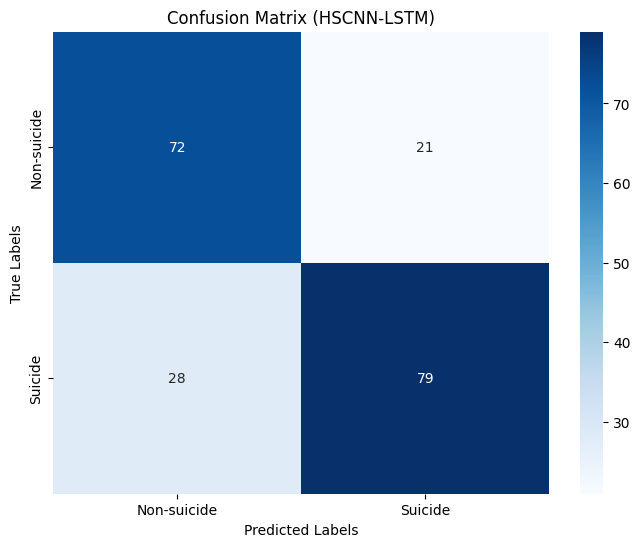

In [40]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, lstm_y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (HSCNN-LSTM)')
plt.show()

Text & Personality Traits


In [41]:
# Keep the desired columns
data = data[['text','Openness to Experience', 'Conscientiousness', 'Extraversion', 'Agreeableness', 'Neuroticism', 'class']]

# Encode the 'class' column as a numeric type
data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})

# Remove the percentage symbols and convert the data to floating numbers
data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
data['Conscientiousness'] = data['Conscientiousness'].str.rstrip('%').astype(float)
data['Extraversion'] = data['Extraversion'].str.rstrip('%').astype(float)
data['Agreeableness'] = data['Agreeableness'].str.rstrip('%').astype(float)
data['Neuroticism'] = data['Neuroticism'].str.rstrip('%').astype(float)

# Check the data type of each column
print(data.dtypes)
data

text                       object
Openness to Experience    float64
Conscientiousness         float64
Extraversion              float64
Agreeableness             float64
Neuroticism               float64
class                       int64
dtype: object


C:\Users\PC\AppData\Local\Temp\ipykernel_4948\3006196770.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['class'] = data['class'].map({'non-suicide': 0, 'suicide': 1})
C:\Users\PC\AppData\Local\Temp\ipykernel_4948\3006196770.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Openness to Experience'] = data['Openness to Experience'].str.rstrip('%').astype(float)
C:\Users\PC\AppData\Local\Temp\ipykernel_4948\3006196770.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

,text,Openness to Experience,Conscientiousness,Extraversion,Agreeableness,Neuroticism,class
0,Ex Wife Threatening SuicideRecently I left my ...,51.0,68.0,27.0,35.0,67.0,1
1,Am I weird I don't get affected by compliments...,98.0,0.0,1.0,17.0,100.0,0
2,Finally 2020 is almost over... So I can never ...,89.0,7.0,1.0,11.0,56.0,0
3,"Everyone wants to be ""edgy"" and it's making me...",97.0,12.0,22.0,26.0,93.0,0
4,I took the rest of my sleeping pills and my pa...,98.0,69.0,0.0,63.0,90.0,1
...,...,...,...,...,...,...,...
995,I'm a 17 year old senior and I sometimes feel ...,75.0,37.0,26.0,36.0,85.0,1
996,I just want to go to sleep and not wake upI ha...,76.0,21.0,0.0,17.0,97.0,1
997,Help. I'm so lost.I feel so helpless despite t...,88.0,25.0,18.0,15.0,99.0,1
998,Anybody else get really scared when you get cl...,98.0,41.0,49.0,54.0,98.0,1


In [42]:
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    my_stopwords = set(stopwords.words('english'))
    add_stopwords = ['#ff', 'ff', 'rt']
    my_stopwords.update(add_stopwords)
    tokenizer = TweetTokenizer(reduce_len=True)
    lemmatizer = WordNetLemmatizer()

    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove punctuations and numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)

    # Lowercasing
    text = text.lower()

    # Tokenization
    tokens = tokenizer.tokenize(text)

    # Remove stop word
    tokens = [word for word in tokens if word not in my_stopwords]

    # Lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    text = ' '.join(tokens)

    return text

data['preprocessed_text'] = data.text.apply(preprocess_text)
data[['text','preprocessed_text']].head(10)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\PC\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\PC\AppData\Local\Temp\ipykernel_4948\2335640508.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['preprocessed_text'] = data.text.apply(preprocess_text)


,text,preprocessed_text
0,Ex Wife Threatening SuicideRecently I left my ...,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,weird get affected compliment coming someone k...
2,Finally 2020 is almost over... So I can never ...,finally almost never hear bad year ever swear ...
3,"Everyone wants to be ""edgy"" and it's making me...",everyone want edgy making self conscious feel ...
4,I took the rest of my sleeping pills and my pa...,took rest sleeping pill painkillersi wait end ...
5,Can you imagine getting old? Me neither.Wrinkl...,imagine getting old neither wrinkle weight gai...
6,Do you think getting hit by a train would be p...,think getting hit train would painful gun hard...
7,"death, continuedI posted here before and saw s...",death continuedi posted saw something interest...
8,Fuck the verizon smart family app I can’t even...,fuck verizon smart family app even watch porn ...
9,I’m scared. Everything just seems to be gett...,scared everything seems getting worse worse yo...


In [43]:
y = data['class']
X_train1, X_test1, y_train1, y_test1 = train_test_split(data['preprocessed_text'], y, test_size=0.2, random_state=42)


In [44]:
from gensim.models import KeyedVectors
from keras.utils import to_categorical

# Train set and test set split
y = data['class']
X_train, X_test, y_train, y_test = train_test_split(data[['preprocessed_text', 'Extraversion', 'Agreeableness', 'Neuroticism']], y, test_size=0.2, random_state=42)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train['preprocessed_text'])

X_train_seq = tokenizer.texts_to_sequences(X_train['preprocessed_text'])
X_test_seq = tokenizer.texts_to_sequences(X_test['preprocessed_text'])

num_classes = 2
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

max_length = max([len(seq) for seq in X_train_seq] + [len(seq) for seq in X_test_seq])

X_train_padded = pad_sequences(X_train_seq, maxlen=max_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length)

# Extract Big 5 personality scores
train_scores = X_train[['Extraversion', 'Agreeableness', 'Neuroticism']].values
test_scores = X_test[['Extraversion', 'Agreeableness', 'Neuroticism']].values

# Load GoogleNews pre-trained word vectors
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

# Create the word embedding matrix
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    try:
        embedding_vector = word2vec[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        pass

2025-03-26 14:58:53,881 - gensim.models.keyedvectors - INFO - loading projection weights from GoogleNews-vectors-negative300.bin
2025-03-26 15:00:18,449 - gensim.utils - INFO - KeyedVectors lifecycle event {'msg': 'loaded (3000000, 300) matrix of type float32 from GoogleNews-vectors-negative300.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2025-03-26T15:00:18.449668', 'gensim': '4.3.3', 'python': '3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.26100-SP0', 'event': 'load_word2vec_format'}


In [ ]:
from keras.models import Model
from keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Concatenate, Bidirectional, LSTM, Dense, Dropout
from keras.layers import Flatten

# Construct the model
embedding_dim = 300
filters = 100
kernel_size = 5
lstm_units = 100
dropout_rate = 0.3
num_heads = 5

text_input = Input(shape=(max_length,), name='text_input')
x = Embedding(num_words, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(text_input)
x = Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(x)
x = MaxPooling1D()(x)
x = LSTM(lstm_units, return_sequences=True)(x)

x = MultiHeadAttention(num_heads=num_heads, key_dim=embedding_dim)(x, x)
x = Flatten()(x)

personality_input = Input(shape=(3,), name='personality_input')
p = Dense(32, activation='relu')(personality_input)

combined = Concatenate()([x, p])

x = Dense(units=64, activation='relu')(combined)
x = Dropout(dropout_rate)(x)
output = Dense(units=num_classes, activation='softmax')(x)

model_2 = Model(inputs=[text_input, personality_input], outputs=output)
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [66]:
from psokeras.particle import Particle
from sklearn.metrics import classification_report
import keras

BIG_SCORE = 1.e6  # Large initial score

class ProgressBar:
    def __init__(self, steps, updates=10):
        self.step = 0
        self.step_size = (steps // updates)
        self.total_steps = steps
        self.updates = updates

        bar = self._make_bar(0)
        print(bar, end=' ')

    def update(self, i):
        if i % self.step_size > 0:
            return

        self.step = i // self.step_size
        bar = self._make_bar(i)
        print(bar, end=' ')

    def done(self):
        self.step = self.total_steps
        bar = self._make_bar(self.updates)
        print(bar)

    def _make_bar(self, x):
        bar = "["
        for x in range(self.updates):
            print("\r", end=' ')
            bar += "=" if x < self.step else " "
        bar += "]"
        return bar

class CustomParticle(Particle):  
    def get_score(self, x, y, update=True):
        local_score = self.model.evaluate(x, y, verbose=0)

        if isinstance(local_score, list):  # Ensure loss is a single float value
            local_score = local_score[0]  

        if local_score < self.best_score and update:
            self.best_score = local_score
            self.best_weights = self.model.get_weights()

        return local_score  

class Optimizer:
    def __init__(self, model, loss, n=10, acceleration=0.1, local_rate=1.0, global_rate=1.0):
        self.n_particles = n
        self.structure = model.to_json()
        self.particles = [None] * n
        self.loss = loss
        self.length = len(model.get_weights())

        params = {'acc': acceleration, 'local_acc': local_rate, 'global_acc': global_rate}

        for i in range(n - 1):
            m = keras.models.model_from_json(self.structure)
            m.compile(loss=loss, optimizer='sgd')
            self.particles[i] = CustomParticle(m, params)  # Use the overridden class

        self.particles[n - 1] = CustomParticle(model, params)  # Last particle is original model

        self.global_best_weights = None
        self.global_best_score = BIG_SCORE

    def fit(self, x, y, steps=0, batch_size=32):
        num_samples = x[0].shape[0] if isinstance(x, list) else x.shape[0]  
        num_batches = num_samples // batch_size  

        for i, p in enumerate(self.particles):
            local_score = p.get_score(x, y)

            if local_score < self.global_best_score:
                self.global_best_score = local_score
                self.global_best_weights = p.get_best_weights()

        print("PSO -- Initial best score {:0.4f}".format(self.global_best_score))

        bar = ProgressBar(steps, updates=20)

        for i in range(steps):
            for j in range(num_batches):
                if isinstance(x, list):
                    x_batch = [x_i[j * batch_size:(j + 1) * batch_size] for x_i in x]
                else:
                    x_batch = x[j * batch_size:(j + 1) * batch_size, :]

                y_batch = y[j * batch_size:(j + 1) * batch_size]

                for p in self.particles:
                    local_score = p.step(x_batch, y_batch, self.global_best_weights)

                    if local_score < self.global_best_score:
                        self.global_best_score = local_score
                        self.global_best_weights = p.get_best_weights()

            bar.update(i)

        bar.done()

    def get_best_model(self):
        best_model = keras.models.model_from_json(self.structure)
        best_model.set_weights(self.global_best_weights)
        best_model.compile(loss=self.loss, optimizer='adam')  
        return best_model


In [67]:
# Define PSO parameters
batch_size = 32
n_particles = 10
steps = 50

# Initialize the PSO optimizer
pso = Optimizer(model=model_2, loss='categorical_crossentropy', n=n_particles, acceleration=1.0, local_rate=0.6, global_rate=0.4)

pso.fit([X_train_padded, X_train[['Extraversion', 'Agreeableness', 'Neuroticism']]], 
        y_train, steps=steps, batch_size=batch_size)

# Retrieve the best model
best_weights = pso.global_best_weights  # get best weights from PSO
model_2.set_weights(best_weights)
model_2.compile(loss='categorical_crossentropy', optimizer='adam')  # recompile with Adam optimizer

# Evaluate the model on the test set
y_prob = model_2.predict([X_test_padded, X_test[['Extraversion', 'Agreeableness', 'Neuroticism']]])
y_pred = np.argmax(y_prob, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

print('HSCNN-LSTM Results:')
print(classification_report(y_test_labels, y_pred, digits=4))


PSO -- Initial best score 0.8118
 [====================] 
7/7 [==============================] - 1s 30ms/step
HSCNN-LSTM Results:
              precision    recall  f1-score   support

           0     0.6475    0.8495    0.7349        93
           1     0.8205    0.5981    0.6919       107

    accuracy                         0.7150       200
   macro avg     0.7340    0.7238    0.7134       200
weighted avg     0.7401    0.7150    0.7119       200



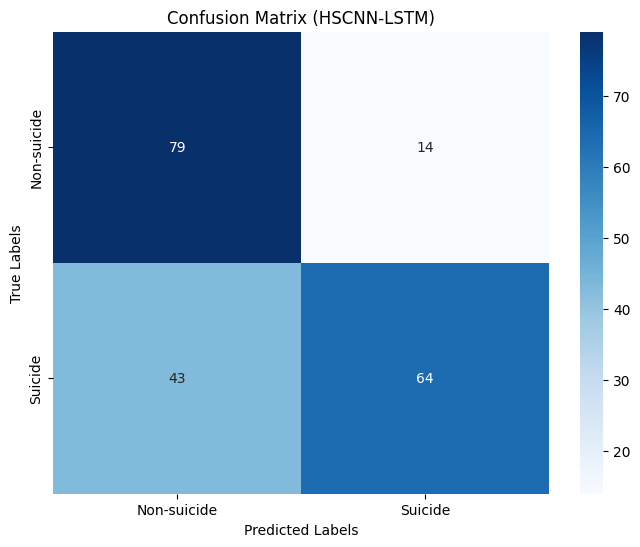

In [68]:
# Calculate confusion matrix
rf_cm = confusion_matrix(y_test_labels, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-suicide', 'Suicide'], yticklabels=['Non-suicide', 'Suicide'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix (HSCNN-LSTM)')
plt.show()